# Import the Required Packages 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark-3.0.1-bin-hadoop2.7'

# Load the Dataset 

In [2]:
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
sdf = spark.read.csv('D:/DataSets/bank.csv', header = True, inferSchema = True)
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Create a DF with details

In [3]:
pd.DataFrame(sdf.take(5), columns=sdf.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Check the Unique values in Deposit column

In [4]:
sdf.toPandas().groupby(['deposit']).size()

deposit
no     5873
yes    5289
dtype: int64

## Summary statistics for numeric variables 

In [5]:
numeric_features = [t[0] for t in sdf.dtypes if t[1] == 'int']
sdf.select(numeric_features).describe().toPandas()

,summary,age,balance,day,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,15.658036194230425,371.99381831213043,2.508421429851281,51.33040673714388,0.8325568894463358
2,stddev,11.913369192215518,3225.413325946149,8.420739541006462,347.12838571630687,2.7220771816614824,108.75828197197717,2.292007218670508
3,min,18,-6847,1,2,1,-1,0
4,max,95,81204,31,3881,63,854,58


## Correlations between independent variables

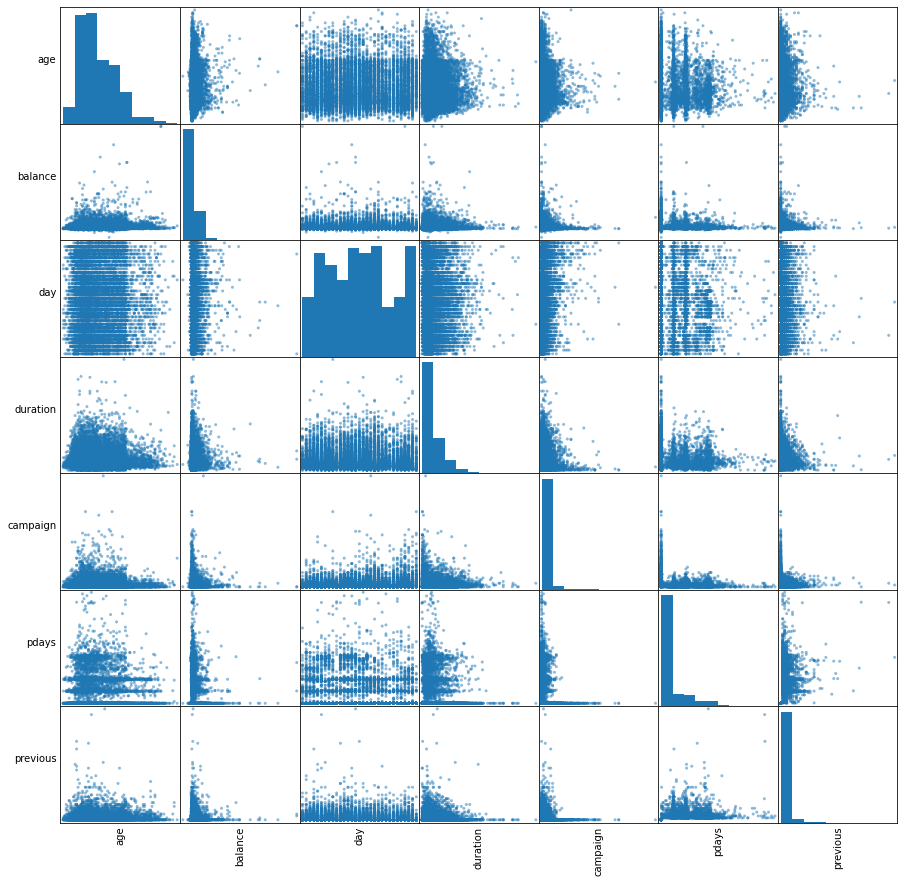

In [7]:
numeric_data = sdf.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(15, 15));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [8]:
sdf = sdf.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = sdf.columns
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Preparing Dataset for Machine Learning

In [13]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Pipeline

In [14]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(sdf)
sdf = pipelineModel.transform(sdf)
selectedCols = ['label', 'features'] + cols
sdf = sdf.select(selectedCols)
sdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [15]:
pdf = pd.DataFrame(sdf.take(5), columns=sdf.columns)
pdf.iloc[:,0:2] 

,label,features
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
len(pdf.features[0])

30

# Split dataset into train and test set

In [17]:
train, test = sdf.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


# Model Building

In [18]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

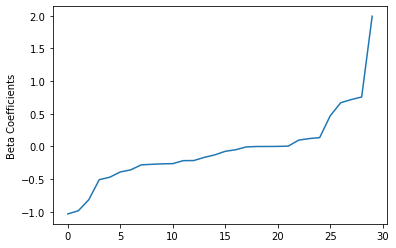

In [19]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

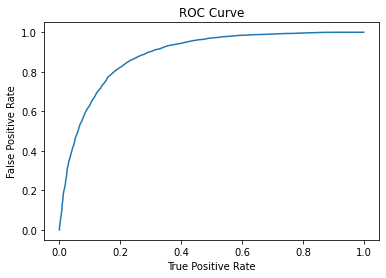

Training set areaUnderROC: 0.8865478305561797


In [20]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Precision and recall

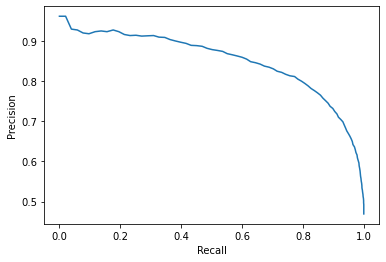

In [21]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Make predictions on the test set

In [22]:
lrPreds = lrModel.transform(test)
lrPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93500470498078...|       0.0|[0.87380233100701...|
| 49|management|  0.0|[2.04809361205495...|       0.0|[0.88575484704982...|
| 52|management|  0.0|[-0.7002122133357...|       1.0|[0.33176517908283...|
| 53|management|  0.0|[1.03431610227355...|       0.0|[0.73775180622517...|
| 58|management|  0.0|[2.74273671692568...|       0.0|[0.93950183380104...|
| 32|management|  0.0|[1.25033004378243...|       0.0|[0.77735698810450...|
| 57|management|  0.0|[1.19540519867322...|       0.0|[0.76770638557283...|
| 52|management|  0.0|[3.26456982709638...|       0.0|[0.96319314409492...|
| 46|management|  0.0|[2.15036209979034...|       0.0|[0.89570260888977...|
| 31|management|  0.0|[1.47751802200863...|       0.0|[0.81419739986183...|
+---+-------

In [23]:
lrPreds.show()

+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+-------+--------------------+--------------------+----------+
|label|            features|age|       job|marital|education|default|balance|housing|loan|  contact|duration|campaign|pdays|previous|poutcome|deposit|       rawPrediction|         probability|prediction|
+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+-------+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...| 33|management|married|secondary|     no|    333|     no|  no| cellular|      80|       6|   -1|       0| unknown|     no|[1.93500470498078...|[0.87380233100701...|       0.0|
|  0.0|(30,[0,11,13,16,1...| 49|management|married|secondary|     no|   1601|     no|  no| cellular|      47|       5|   -1|       0| unknown|     no|[2.04809361205495...|[0.8857548470

# Evaluate the Logistic Regression model

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lrEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', lrEval.evaluate(lrPreds))

Test Area Under ROC 0.8837112925002687


# Decision Tree Classifier

In [25]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
dtPreds = dtModel.transform(test)
dtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

# Evaluate the Decision Tree model

In [26]:
dtEval = BinaryClassificationEvaluator()
dtROC = dtEval.evaluate(dtPreds, {dtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(dtROC))

Test Area Under ROC: 0.7808118726917547


# Random Forest Classifier 

In [27]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfPreds = rfModel.transform(test)
rfPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[15.2127743255423...|       0.0|[0.76063871627711...|
| 49|management|  0.0|[14.8769080641441...|       0.0|[0.74384540320720...|
| 52|management|  0.0|[7.33961215047628...|       1.0|[0.36698060752381...|
| 53|management|  0.0|[13.9886999219828...|       0.0|[0.69943499609914...|
| 58|management|  0.0|[15.3666085089977...|       0.0|[0.76833042544988...|
| 32|management|  0.0|[14.5843065870271...|       0.0|[0.72921532935135...|
| 57|management|  0.0|[14.2683253227781...|       0.0|[0.71341626613890...|
| 52|management|  0.0|[16.4203033934495...|       0.0|[0.82101516967247...|
| 46|management|  0.0|[16.2545259632162...|       0.0|[0.81272629816081...|
| 31|management|  0.0|[14.6906262183300...|       0.0|[0.73453131091650...|
+---+-------

## Evaluate the Random Forest Classifier

In [28]:
rfEval = BinaryClassificationEvaluator()
rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(rfROC))

Test Area Under ROC: 0.8796816561669869


# Gradient-Boosted Tree Classifier

In [29]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
gbtPreds = gbtModel.transform(test)
gbtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[0.94992370947246...|       0.0|[0.86987425549896...|
| 49|management|  0.0|[1.28281748604659...|       0.0|[0.92861688965145...|
| 52|management|  0.0|[-0.5021429054421...|       1.0|[0.26809961471379...|
| 53|management|  0.0|[0.09646513340517...|       0.0|[0.54808351175538...|
| 58|management|  0.0|[1.05831377292163...|       0.0|[0.89250881497055...|
| 32|management|  0.0|[0.57268875896254...|       0.0|[0.75866558918304...|
| 57|management|  0.0|[0.34932946844840...|       0.0|[0.66789037418062...|
| 52|management|  0.0|[1.33264456943866...|       0.0|[0.93494709840561...|
| 46|management|  0.0|[1.28262818068783...|       0.0|[0.92859178839697...|
| 31|management|  0.0|[1.16094954405484...|       0.0|[0.91067454521219...|
+---+-------

## Evaluate the Gradient-Boosted Tree Classifier 

In [30]:
gbtEval = BinaryClassificationEvaluator()
gbtROC = gbtEval.evaluate(gbtPreds, {gbtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(gbtROC))

Test Area Under ROC: 0.8935091626908479


In [31]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [32]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=gbtEval, numFolds=5)

# Run cross validations.  
# This can take some minutes since it is training over 20 trees!
cvModel = cv.fit(train)
cvPreds = cvModel.transform(test)
gbtEval.evaluate(cvPreds)

0.8954073787704387